### tsdGAN: A generative adversarial network approach for removing electrocardiographic interference from electromyographic signals 
Lucas Haberkamp<sup>1,2</sup>, Charles A. Weisenbach<sup>1</sup>, Peter Le<sup>3</sup>  
<sup>1</sup>Naval Medical Research Unit Dayton, Wright-Patterson Air Force Base, OH, USA   
<sup>2</sup>Leidos, Reston, VA, USA   
<sup>3</sup>Air Force Research Laboratory, 711th Human Performance Wing, Wright-Patterson Air Force Base, OH, USA 

#### This notebook is used to evaluate dynamic filtration as outlined in "Christov et al. (2018): Separation of electrocardiographic from electromyographic signals using dynamic filtration"

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pickle

Load in synthetic validation dataset

In [19]:
with open('../../Data/Preprocessed Data/Synthetic/Validation/x_val.pkl', 'rb') as f:
  x_val = pickle.load(f)

with open('../../Data/Preprocessed Data/Synthetic/Validation/y_val.pkl', 'rb') as f:
  y_val = pickle.load(f)

with open('../../Data/Preprocessed Data/Synthetic/Validation/label_val.pkl', 'rb') as f:
  label_val = pickle.load(f)

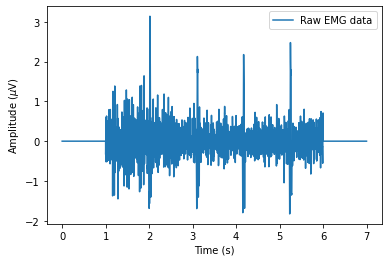

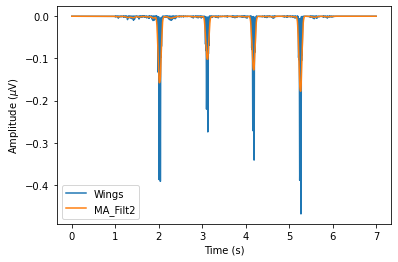

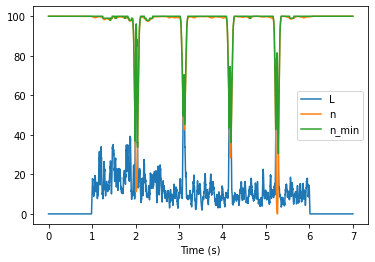

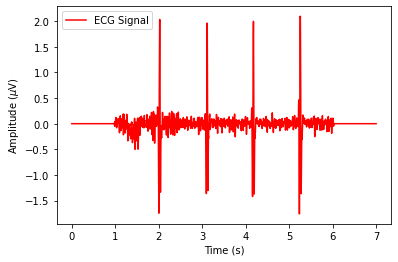

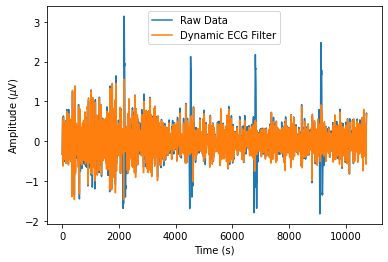

In [20]:
Fs = 2148

def dynamic_ecg_filter(raw_data, fs, plot=False):
        
    pad_length = fs

    # Pad the data with zeros to allow template subtraction at ends of the signal
    emg_data = np.hstack([np.zeros(shape=(pad_length,)), raw_data.squeeze(), np.zeros(shape=(pad_length,))])

    # Section 1: Moving Average Filter (0.02s)
    win_size1 = round(fs * .02)
    ma_filt = pd.Series(emg_data).rolling(window=win_size1, min_periods=1, center=True).mean()

    # Section 2: Savitzky-Golay Filter (0.06s)
    win_size2 = round(fs * 0.06)
    # Make sure window size is not odd
    if not win_size2 % 2 == 0:
        win_size2 += 1 
    sg_filt = signal.savgol_filter(ma_filt, window_length=win_size2, polyorder=2)  # Assuming 2nd order

    # Section 3: Wings Calculation
    wings_win = round(fs * 0.01) # 0.01s
    wings = np.zeros_like(sg_filt)
    for ii in range(len(sg_filt)):
        if (ii > wings_win) and (ii < (len(emg_data)-wings_win)):
            wings[ii] = -np.abs((sg_filt[ii] - sg_filt[ii - wings_win]) * (sg_filt[ii] - sg_filt[ii + wings_win]))
        else:
            wings[ii] = 0

    # Section 4: Moving Average Filters (Apply 2 0.05s moving avg filters)
    ma_filt1 = pd.Series(wings).rolling(window=int(np.ceil(fs * 0.05)), min_periods=1, center=True).mean()
    ma_filt2 = pd.Series(ma_filt1).rolling(window=int(np.ceil(fs * 0.05)), min_periods=1, center=True).mean()

    if plot:
        t = np.arange(len(emg_data))/Fs

        plt.plot(t, emg_data, label='Raw EMG data')
        plt.ylabel("Amplitude ($\mu$V)")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()

        plt.plot(t, wings, label='Wings')
        plt.plot(t, ma_filt2, label='MA_Filt2')
        plt.ylabel("Amplitude ($\mu$V)")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()

    # Section 6: Normalization
    wmax, wmin = ma_filt2.max(), ma_filt2.min()
    nmin, nmax = 0, 100
    n = nmin + (nmax - nmin) * (ma_filt2 - wmin) / (wmax - wmin)

    # Section 7: Calculation of L
    len_data = len(emg_data)
    L = np.zeros_like(emg_data)
    for ii in range(len_data):
        if ii > 25 and ii < len_data - 25:
            L[ii] = np.sum(np.abs(emg_data[ii - 25:ii + 26]))
        elif ii <= 25:
            L[ii] = np.sum(np.abs(emg_data[:ii + 26]))  # Sum from the start to ii + 25
        else:  # ii >= len_data - 25
            L[ii] = np.sum(np.abs(emg_data[ii - 25:]))  # Sum from ii - 25 to the end

    # Section 8: Combination of Results
    n_lim = np.where(n < L, L, np.ceil(n))

    if plot:
        plt.plot(t, L, label='L')
        plt.plot(t, n, label='n')
        plt.plot(t, n_lim, label='n_min')
        plt.xlabel("Time (s)")
        plt.legend()
        plt.legend()
        plt.show()

    # Section 9: Ensure nLim is odd and greater than 2
    n_lim_est = np.ceil(n_lim).astype(int)

    n_lim_est_corrected = np.empty_like(n_lim_est)
    for i in range(len(n_lim_est)):
        if n_lim_est[i] % 2 == 1 and n_lim_est[i] > 2:
            n_lim_est_corrected[i] = n_lim_est[i]
        elif n_lim_est[i] % 2 == 1 and n_lim_est[i] <= 3:
            n_lim_est_corrected[i] = 3
        elif n_lim_est[i] == 0:
            n_lim_est_corrected[i] = 3
        else:
            n_lim_est_corrected[i] = n_lim_est[i] + 1

    # Section 10: Apply dynamic Savitzky-Golay filter
    max_window_length = n_lim_est_corrected.max() - 1
    pad_ends = np.zeros(max_window_length)
    zero_padded_data = np.concatenate((pad_ends, emg_data, pad_ends))
    ecg_filtered = np.zeros_like(emg_data)

    for ii in range(len(emg_data)):
        current_idx = ii + max_window_length
        iteration_length = (n_lim_est_corrected[ii] - 1) // 2
        data_to_filter = zero_padded_data[current_idx - iteration_length:current_idx + iteration_length + 1]
        filtered_data = signal.savgol_filter(data_to_filter, window_length=n_lim_est_corrected[ii], polyorder=2)
        ecg_filtered[ii] = filtered_data[iteration_length + 1]

    if plot:
        plt.plot(t, ecg_filtered, color='r', label='ECG Signal')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude ($\mu$V)")
        plt.legend()
        plt.show()
    
    # Section 11: What we want 
    filt_emg = emg_data - ecg_filtered
    filt_emg = filt_emg[pad_length:-pad_length]

    if plot:
        plt.plot(raw_data, label='Raw Data')
        plt.plot(filt_emg, label='Dynamic ECG Filter')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude ($\mu$V)")
        plt.legend()
        plt.show()
    return filt_emg

snr_level = 1
i = 5    
y_pred = dynamic_ecg_filter(x_val[snr_level][i], fs=Fs, plot=True)


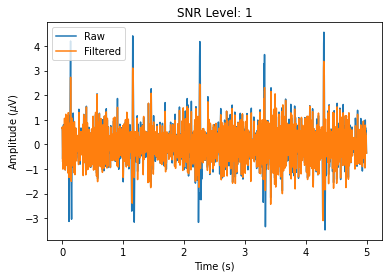

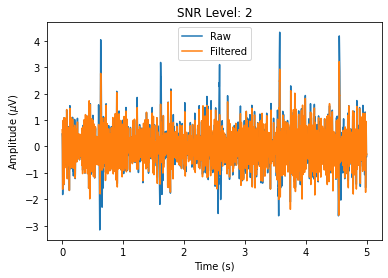

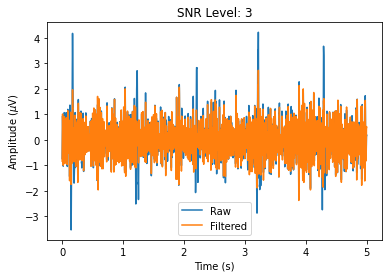

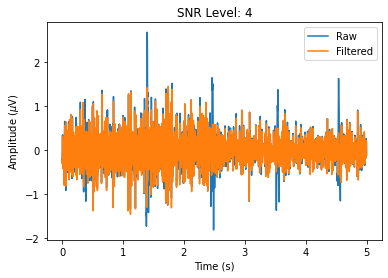

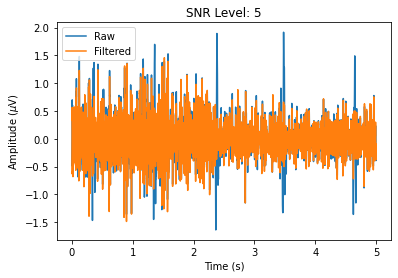

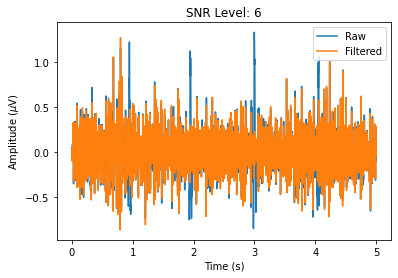

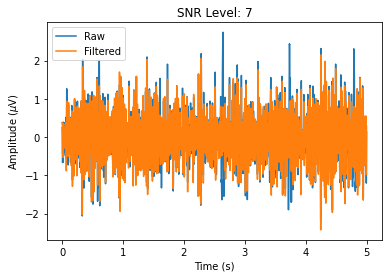

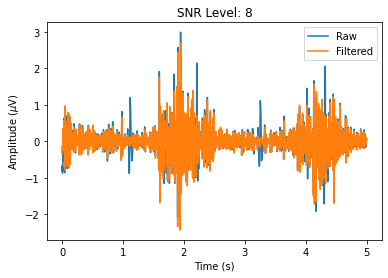

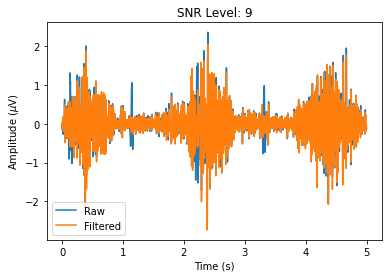

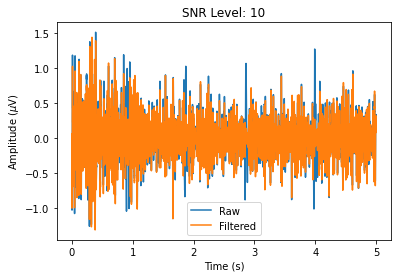

In [21]:
# Define time axis
t = np.arange(len(x_val[1][0]))/Fs

# Apply the template subtraction filter on the validation dataset 
y_pred = {}
for _, key in enumerate(x_val.keys()):
    # Apply the template subtraction method
    y_pred[key] = np.apply_along_axis(dynamic_ecg_filter, axis=1, arr=x_val[key], fs=Fs)

    # Generate plot for each SNR level
    plt.plot(t, x_val[key][0], label='Raw')
    plt.plot(t, y_pred[key][0], label='Filtered')
    plt.ylabel("Amplitude ($\mu$V)")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title(f"SNR Level: {key}")
    plt.show()

In [ ]:
with open('../../Data/Synthetic Predictions/DynamicFiltration.pkl', 'wb') as f:
    pickle.dump(y_pred, f)